In [63]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.metrics import mean_squared_error
from numpy import mean


In [64]:
df = pd.read_csv('rainfall.csv')

In [65]:
df

,date,mean_rainfall
0,1990-01-01,1.613
1,1990-01-11,1.557
2,1990-01-21,2.219
3,1990-02-01,4.788
4,1990-02-11,6.510
...,...,...
1073,2019-11-11,6.737
1074,2019-11-21,5.216
1075,2019-12-01,2.022
1076,2019-12-11,1.780


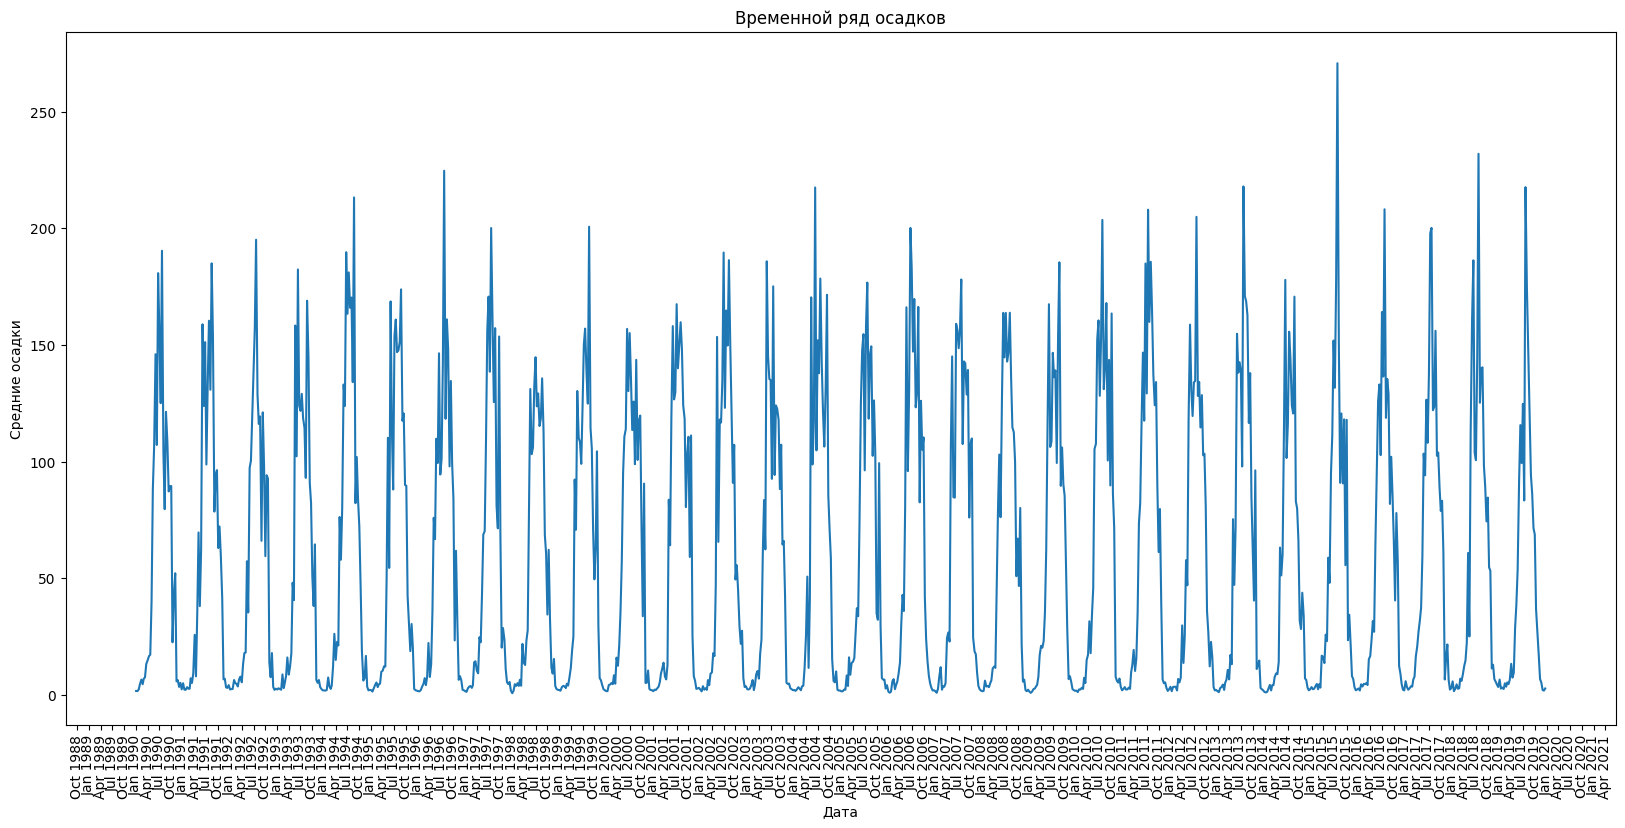

In [66]:
import matplotlib.dates as mdates

# Преобразование столбца 'date' в формат datetime
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)

# Визуализация временного ряда с месяцами на оси X
plt.figure(figsize=(20, 9))
plt.plot(df['mean_rainfall'])
plt.title('Временной ряд осадков')
plt.xlabel('Дата')
plt.ylabel('Средние осадки')

# Добавление форматирования для отображения месяцев с читаемыми названиями
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))  # Интервал в 3 месяца
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=90)  # Поворот подписей месяцев для лучшей видимости

plt.show()



**Предположение:**

**Сезонность:** Возможно, существует сезонность в осадках, так как значения меняются в зависимости от времени года. Вероятно, у нас есть повторяющийся паттерн, который можно выделить при более детальном анализе.


**Тренд:** Кажется, что есть общий тренд к увеличению осадков с течением времени. Если значения действительно увеличиваются или уменьшаются в течение длительного периода времени, это может свидетельствовать о наличии тренда.


**Стационарность:** Судя по графику, временной ряд не выглядит стационарным.



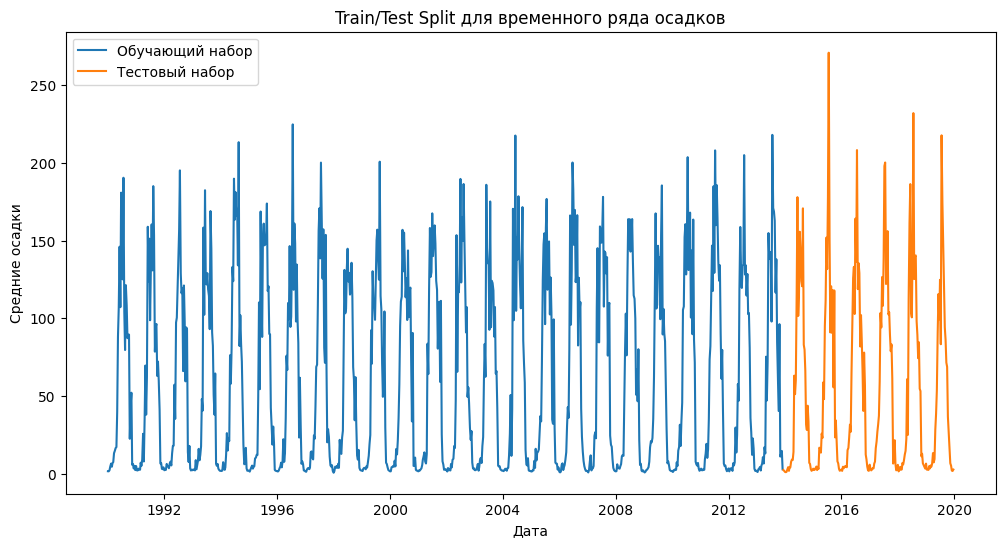

In [67]:
# Разделение данных на train и test
train_size = int(len(df) * 0.8)
train, test = df[:train_size], df[train_size:]

# Визуализация train и test наборов
plt.figure(figsize=(12, 6))
plt.plot(train['mean_rainfall'], label='Обучающий набор')
plt.plot(test['mean_rainfall'], label='Тестовый набор')
plt.title('Train/Test Split для временного ряда осадков')
plt.xlabel('Дата')
plt.ylabel('Средние осадки')
plt.legend()
plt.show()


Предсказываем значения, основываясь на прошлом годе


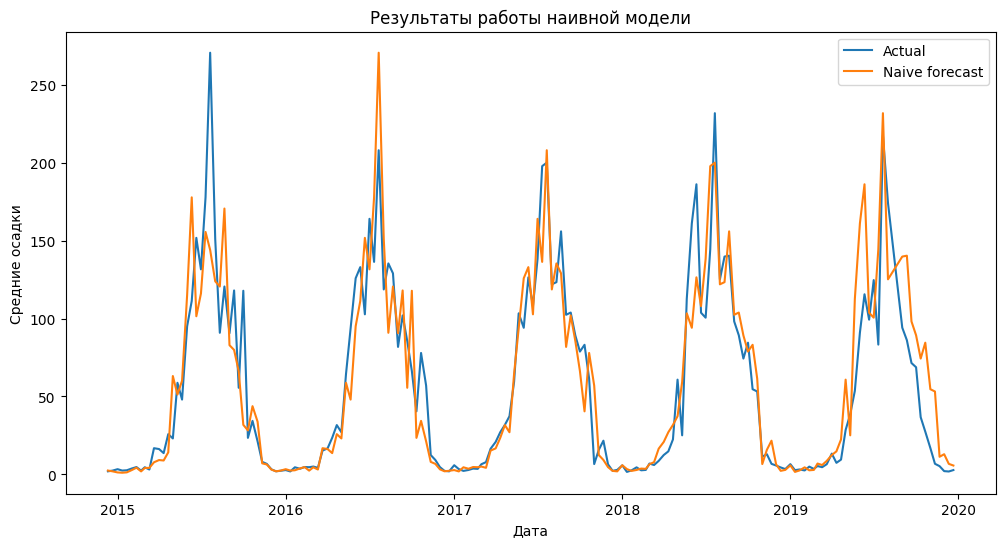

Среднеквадратичная ошибка (MSE) для наивного прогноза: 719.0127416277776


In [68]:
# Наивный прогноз
naive_forecast = test.shift(36)
# Удаление первой строки (NaN после сдвига)
naive_forecast = naive_forecast[36:]

# Убеждаемся, что test и naive_forecast имеют одинаковые индексы
test = test.loc[naive_forecast.index]

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['mean_rainfall'], label='Actual')
plt.plot(naive_forecast.index, naive_forecast['mean_rainfall'], label='Naive forecast')
plt.xlabel('Дата')
plt.ylabel('Средние осадки')
plt.legend()
plt.title('Результаты работы наивной модели')
plt.show()

# Оценка качества бейзлайна
baseline_mse = mean_squared_error(test['mean_rainfall'], naive_forecast['mean_rainfall'])
print(f'Среднеквадратичная ошибка (MSE) для наивного прогноза: {baseline_mse}')

In [69]:
from statsmodels.tsa.stattools import adfuller

# Проведение теста Дики-Фуллера
result = adfuller(df['mean_rainfall'])

# Вывод результатов теста
print('ADF Statistic:', result[0])
print('p-value:', result[1])
print('Critical Values:', result[4])

# Интерпретация результата
if result[1] <= 0.05:
    print("Отвергаем нулевую гипотезу. Ряд стационарен.")
else:
    print("Не отвергаем нулевую гипотезу. Ряд нестационарен.")

ADF Statistic: -17.09253438246042
p-value: 7.573294206434818e-30
Critical Values: {'1%': -3.4365635376940706, '5%': -2.86428345899922, '10%': -2.5682307228049686}
Отвергаем нулевую гипотезу. Ряд стационарен.


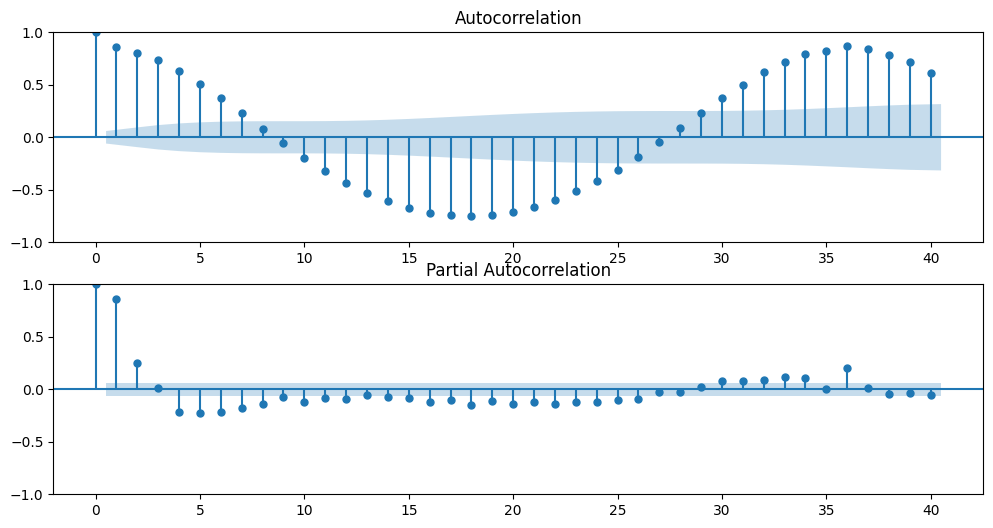

In [70]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Построение графиков ACF и PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(df['mean_rainfall'], ax=plt.gca(), lags=40)
plt.subplot(212)
plot_pacf(df['mean_rainfall'], ax=plt.gca(), lags=40)
plt.show()

Сезонность присутствует, сделаем необходимые преобразования

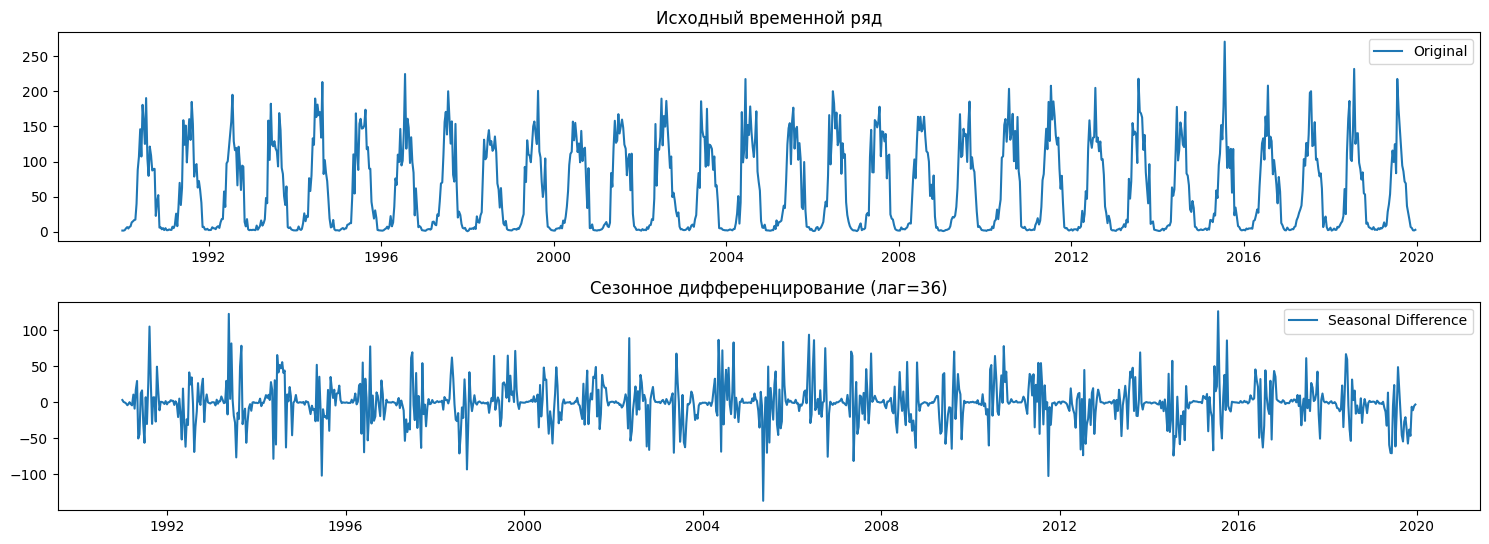

In [71]:
# Дифференцирование
df['diff_seasonal'] = df['mean_rainfall'].diff(36)  # Пример: сезонное дифференцирование с лагом 36

# Построение графиков для анализа результатов дифференцирования
plt.figure(figsize=(15, 8))

# Исходный временной ряд
plt.subplot(311)
plt.plot(df['mean_rainfall'], label='Original')
plt.title('Исходный временной ряд')
plt.legend()

# Сезонное дифференцирование
plt.subplot(312)
plt.plot(df['diff_seasonal'], label='Seasonal Difference')
plt.title('Сезонное дифференцирование (лаг=36)')
plt.legend()

plt.tight_layout()
plt.show()

ADF Statistic: -17.294242198923907
p-value: 5.6799236716833946e-30
Critical Values: {'1%': -3.436659460539809, '5%': -2.864325767240336, '10%': -2.5682532565554537}


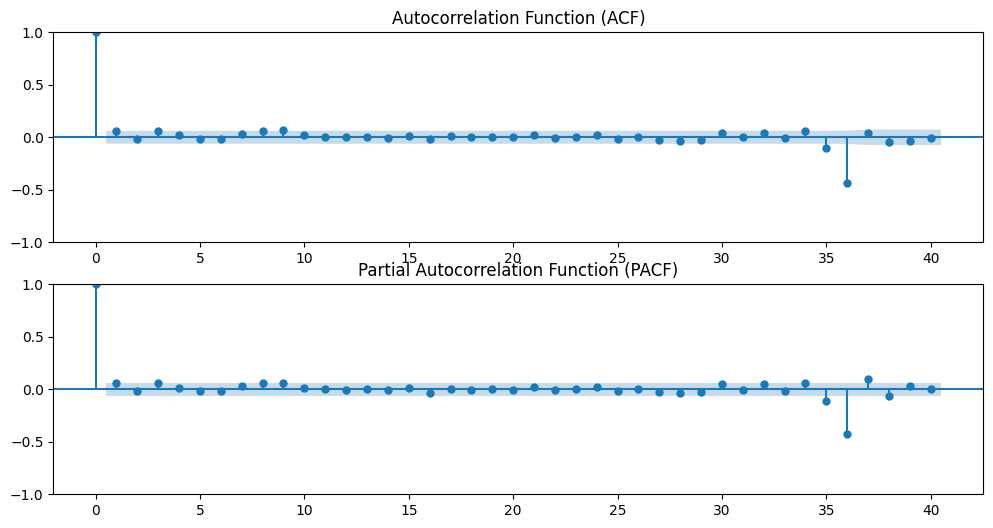

Отвергаем нулевую гипотезу. Ряд стационарен.


In [72]:
# Функция для теста Дики-Фуллера и визуализации ACF/PACF
def check_stationarity(data, column_name, lags=40):
    # Тест Дики-Фуллера
    result = adfuller(data[column_name].dropna())
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'Critical Values: {result[4]}')

    # Визуализация ACF/PACF
    plt.figure(figsize=(12, 6))
    plt.subplot(211)
    plot_acf(data[column_name].dropna(), ax=plt.gca(), lags=lags)
    plt.title('Autocorrelation Function (ACF)')
    plt.subplot(212)
    plot_pacf(data[column_name].dropna(), ax=plt.gca(), lags=lags)
    plt.title('Partial Autocorrelation Function (PACF)')
    plt.show()

# Тест Дики-Фуллера и визуализация ACF/PACF для первого дифференцирования
check_stationarity(df, 'diff_seasonal')

# Интерпретация результата
if result[1] <= 0.05:
    print("Отвергаем нулевую гипотезу. Ряд стационарен.")
else:
    print("Не отвергаем нулевую гипотезу. Ряд нестационарен.")


Дифференцирование дало результаты, видно по графику, что удалось избавиться от сезонности почти полностью

In [73]:
pip install pmdarima


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=10032.843, Time=2.10 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=11899.031, Time=0.06 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=10433.152, Time=0.30 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=11195.708, Time=0.65 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=12617.868, Time=0.03 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=10346.270, Time=0.91 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=10367.611, Time=1.96 sec
 ARIMA(3,0,2)(0,0,0)[0] intercept   : AIC=10035.196, Time=10.25 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=10035.942, Time=10.46 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=10376.548, Time=2.34 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=10288.001, Time=5.22 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=10362.380, Time=9.25 sec
 ARIMA(3,0,3)(0,0,0)[0] intercept   : AIC=inf, Time=13.56 sec
 ARIMA(2,0,2)(0,0,0)[0]             : AIC=10264.216, Time=2.58 sec

Best model:  ARIMA(2,

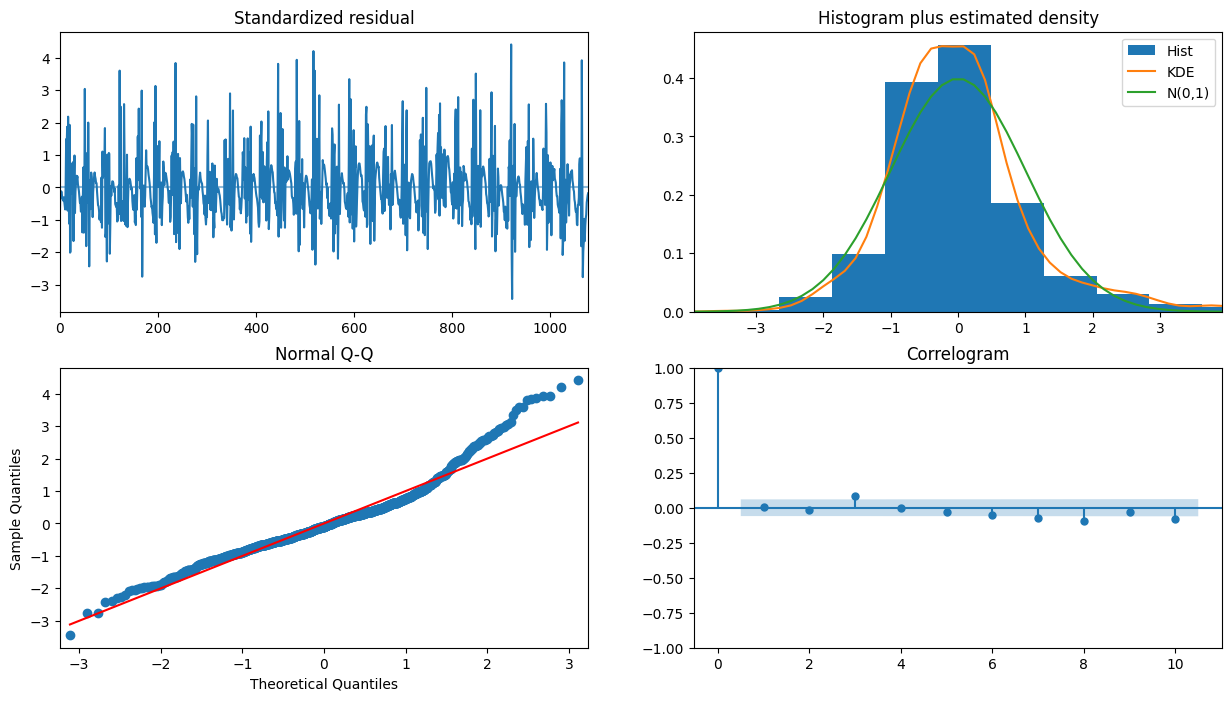

No supported index is available. Prediction results will be given with an integer index beginning at `start`.
No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.


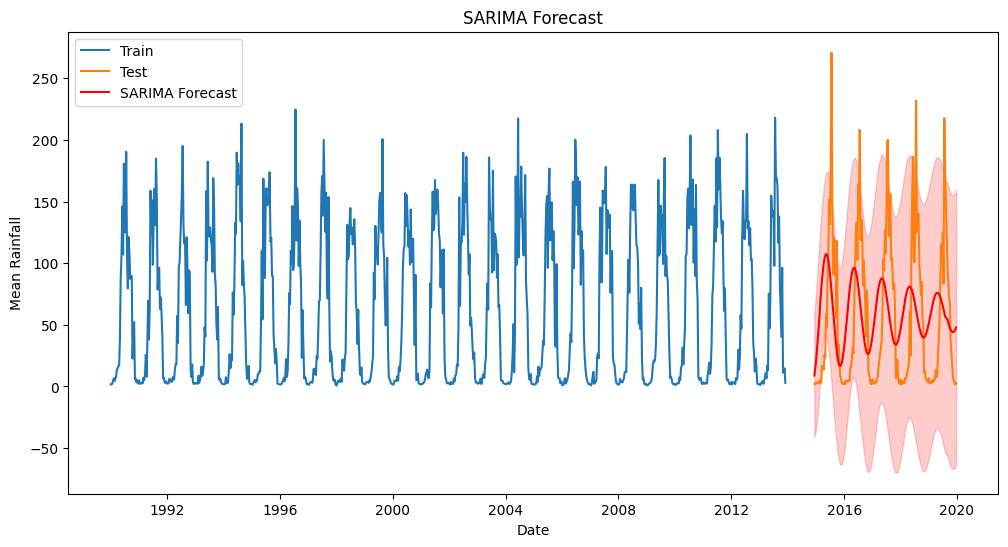

Mean Squared Error (MSE) for SARIMA forecast: 3436.8504914060272


In [74]:
import pmdarima as pm

# Обучение SARIMA модели и подбор параметров
model = pm.auto_arima(df['mean_rainfall'], seasonal=True, stepwise=True, suppress_warnings=True, trace=True)

# Визуализация результатов
model.plot_diagnostics(figsize=(15, 8))
plt.show()

# Прогнозирование на тестовом периоде
forecast, conf_int = model.predict(n_periods=len(test), return_conf_int=True)

# Визуализация результатов прогноза
plt.figure(figsize=(12, 6))
plt.plot(train.index, train['mean_rainfall'], label='Train')
plt.plot(test.index, test['mean_rainfall'], label='Test')
plt.plot(test.index, forecast, label='SARIMA Forecast', color='red')
plt.fill_between(test.index, conf_int[:, 0], conf_int[:, 1], color='red', alpha=0.2)
plt.xlabel('Date')
plt.ylabel('Mean Rainfall')
plt.title('SARIMA Forecast')
plt.legend()
plt.show()

# Замеры качества модели
sarima_mse = mean_squared_error(test['mean_rainfall'], forecast)
print(f'Mean Squared Error (MSE) for SARIMA forecast: {sarima_mse}')

Среднеквадратическая ошибка заметно больше, предложенные параметры дали плохой результат, возможно нужно лучше настроить параметры, чтобы модель работала лучше. Почему то появился разрыв после изменений кода, так и не понял почему, долго сидел.

In [75]:
# Создание лагов
for lag in range(1,37):
    df[f'mean_rainfall_lag_{lag}'] = df['mean_rainfall'].shift(lag)

# Создание скользящих статистик (среднее и стандартное отклонение)
windows = [3, 5, 7]  # список окон для создания скользящих статистик

for window in windows:
    df[f'mean_rainfall_mean_{window}'] = df['mean_rainfall'].rolling(window=window).mean()
    df[f'mean_rainfall_std_{window}'] = df['mean_rainfall'].rolling(window=window).std()

# Создание признаков из даты
df['month'] = df.index.month
df['day'] = df.index.day
df['weekday'] = df.index.weekday

# Удаление строк с пропущенными значениями, возникшими после создания лагов и скользящих статистик
df = df.dropna()

# Переопределение train и test после удаления строк с пропущенными значениями
train = df[df.index < '2019-12-01']
test = df[df.index >= '2019-12-01']


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


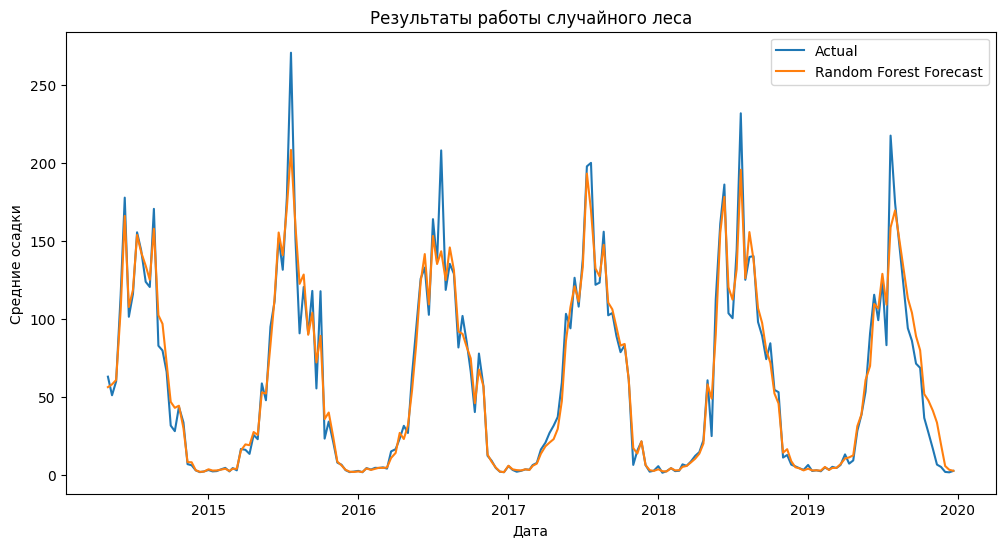

Среднеквадратичная ошибка (MSE) для Random Forest: 140.12214295140612


In [76]:
# Добавление лагов в данные
for lag in range(1,37):
    df[f'mean_rainfall_lag_{lag}'] = df['mean_rainfall'].shift(lag)

# Удаляем строки с пропущенными значениями, которые появились из-за сдвига
df = df.dropna()

# Разделение на train и test
train_size = int(0.8 * len(df))
train, test = df[:train_size], df[train_size:]

# Создание матрицы признаков и вектора ответов
X_train, y_train = train.drop('mean_rainfall', axis=1), train['mean_rainfall']
X_test, y_test = test.drop('mean_rainfall', axis=1), test['mean_rainfall']

# Обучение случайного леса
from sklearn.ensemble import RandomForestRegressor
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Прогноз на тестовом наборе
rf_predictions = rf_model.predict(X_test)

# Визуализация результатов
plt.figure(figsize=(12, 6))
plt.plot(test.index, test['mean_rainfall'], label='Actual')
plt.plot(test.index, rf_predictions, label='Random Forest Forecast')
plt.xlabel('Дата')
plt.ylabel('Средние осадки')
plt.legend()
plt.title('Результаты работы случайного леса')
plt.show()

# Оценка качества случайного леса
rf_mse = mean_squared_error(test['mean_rainfall'], rf_predictions)
print(f'Среднеквадратичная ошибка (MSE) для Random Forest: {rf_mse}')

Среднеквадратическа ошибка намного меньше при таком подходе. Случайный лес показал себя намного лучше, чем SARIMA


Permutation Importance:

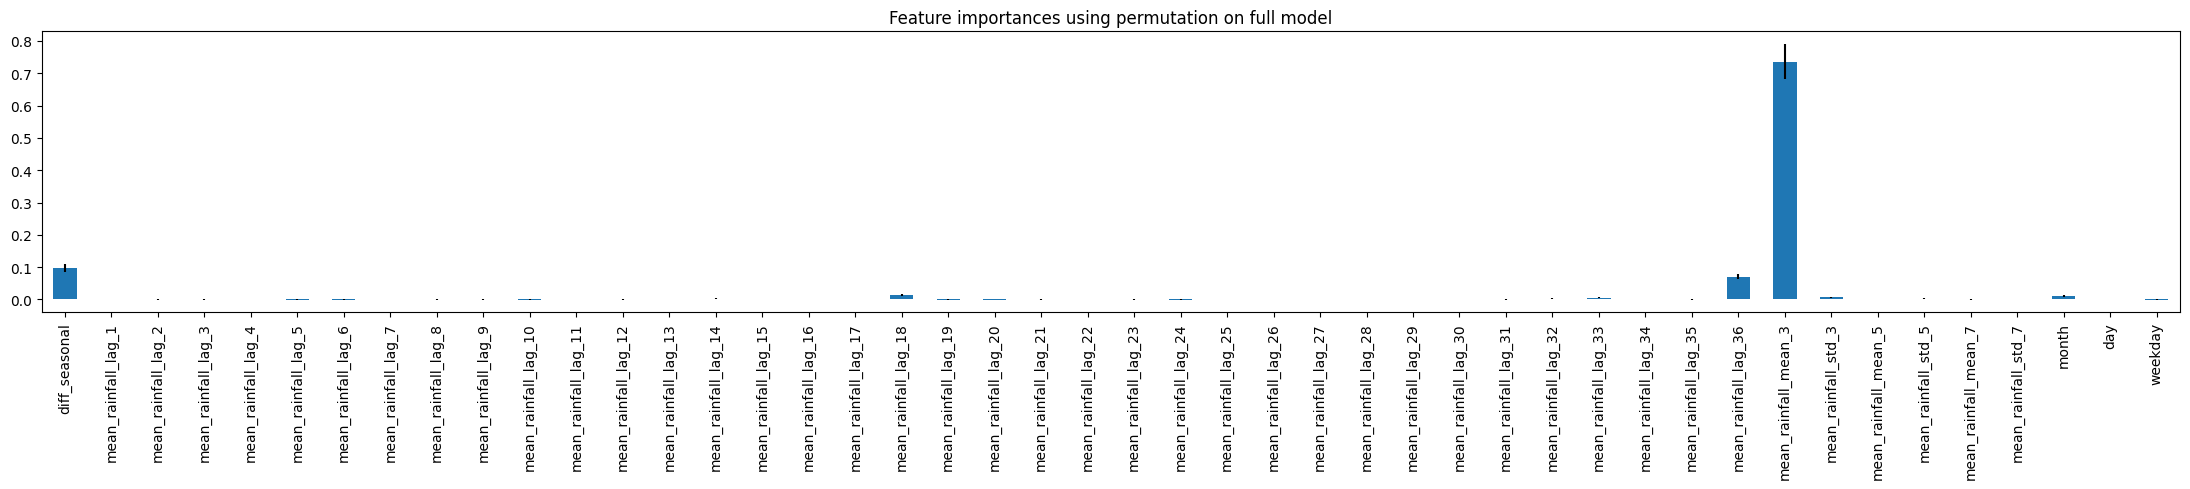

mean_rainfall_mean_3 0.736 ± 0.055
diff_seasonal 0.097 ± 0.012
mean_rainfall_lag_36 0.071 ± 0.008
mean_rainfall_lag_18 0.014 ± 0.003
month    0.010 ± 0.003
mean_rainfall_std_3 0.006 ± 0.001
mean_rainfall_lag_33 0.005 ± 0.002
mean_rainfall_lag_14 0.003 ± 0.001
mean_rainfall_std_5 0.003 ± 0.001
mean_rainfall_lag_32 0.003 ± 0.001
mean_rainfall_lag_15 0.002 ± 0.001
mean_rainfall_lag_17 0.001 ± 0.001
mean_rainfall_lag_29 0.001 ± 0.001
day      0.001 ± 0.000
mean_rainfall_mean_5 0.001 ± 0.001
mean_rainfall_lag_13 0.001 ± 0.000
mean_rainfall_lag_27 0.001 ± 0.000
mean_rainfall_std_7 0.001 ± 0.000
mean_rainfall_lag_34 0.001 ± 0.000
mean_rainfall_lag_1 0.001 ± 0.000
mean_rainfall_lag_16 0.000 ± 0.000
mean_rainfall_lag_30 0.000 ± 0.000
mean_rainfall_lag_22 0.000 ± 0.000
mean_rainfall_lag_11 0.000 ± 0.000
mean_rainfall_lag_25 0.000 ± 0.000
mean_rainfall_lag_26 0.000 ± 0.000
mean_rainfall_lag_7 0.000 ± 0.000
mean_rainfall_lag_28 0.000 ± 0.000
mean_rainfall_lag_21 0.000 ± 0.000
mean_rainfall_lag_35 

In [77]:
from sklearn.inspection import permutation_importance

# Вычисление permutation importance
perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=30, random_state=42)
forest_importances = pd.Series(perm_importance.importances_mean, index=X_test.columns)
plt.figure(figsize=(22, 5))
forest_importances.plot.bar(yerr=perm_importance.importances_std)
plt.title("Feature importances using permutation on full model")
plt.tight_layout()
plt.show()
# Печать важности признаков
feature_names = X_test.columns
for i in perm_importance.importances_mean.argsort()[::-1]:
    print(f"{feature_names[i]:<8} "
          f"{perm_importance.importances_mean[i]:.3f} "
          f"± {perm_importance.importances_std[i]:.3f}")


По графику видно, какие признаки имеют наибольшую значимость

LIME:

In [78]:
!pip install lime

In [83]:
import lime
from lime.lime_tabular import LimeTabularExplainer
def predict_proba(X):
    predictions = rf_model.predict(X)
    return predictions

# Создание LIME Explainer
explainer = lime.lime_tabular.LimeTabularExplainer(X_train.values, feature_names=list(X_train.columns),
                                                   class_names=['mean_rainfall'], mode='regression', random_state=42)

# Выберите объект для интерпретации (здесь выбирается первый объект из тестового набора)
instance_to_interpret = X_test.iloc[0]

# Получение интерпретации для объекта
lime_exp = explainer.explain_instance(instance_to_interpret, predict_proba, num_features=len(X_test.columns))
lime_exp.show_in_notebook()

X does not have valid feature names, but RandomForestRegressor was fitted with feature names


По графику видно, что оказывает наибольшее влияние на предсказанное значение.

SHAP - локальная интерпретация (для одного объекта)

In [84]:
!pip install shap
import shap

# Инициализация SHAP
shap.initjs()

# Инициализация SHAP Explainer
shap_explainer = shap.TreeExplainer(rf_model)

# Вычисление SHAP значений для конкретного объекта
shap_values = shap_explainer.shap_values(instance_to_interpret)

# Визуализация SHAP значений для объекта
shap.force_plot(shap_explainer.expected_value, shap_values, feature_names=list(X_test.columns))

Также на графике видно, какие значения столбцов вносят наибольшее влияние на модель

SHAP - глобальная интерпретация (для всей модели целиком)

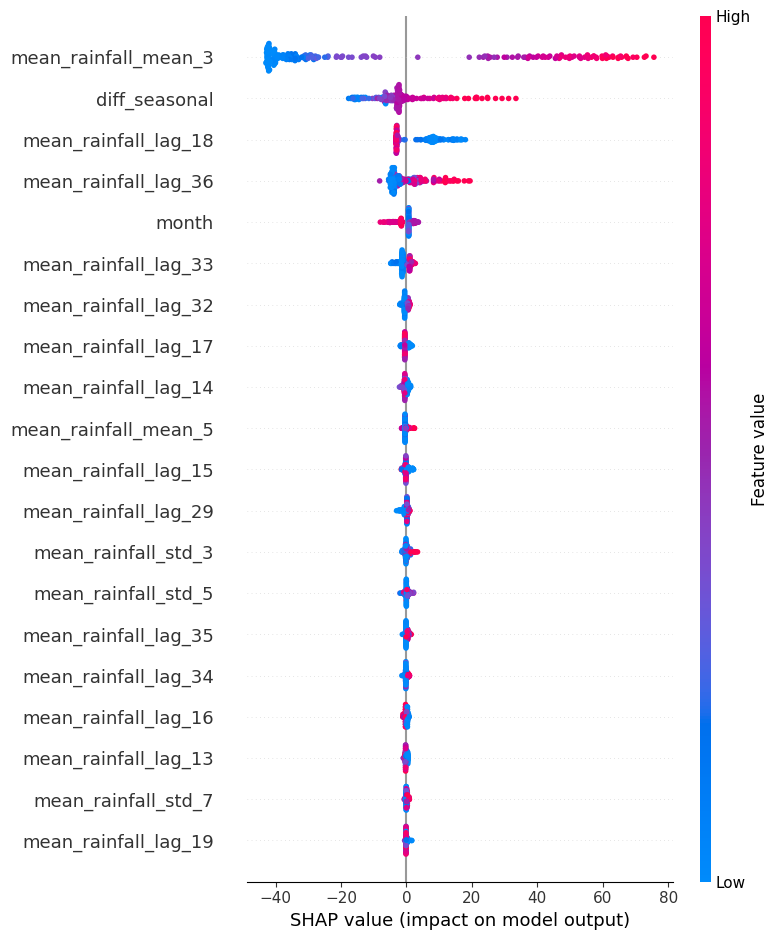

In [85]:
# Вычисление SHAP значений для всего тестового набора
shap_values_all = shap_explainer.shap_values(X_test)

# Визуализация summary plot
shap.summary_plot(shap_values_all, X_test)

Первые четыре признака оказывают наибольшее влияние на предсказание значения